# Import

In [1]:
import pandas as pd
import numpy as np

import dfg_rating.viz.jupyter_widgets as DFGWidgets
from dfg_rating.model.network.base_network import BaseNetwork
from dfg_rating.model.network.multiple_network import LeagueNetwork
from dfg_rating.model.rating.controlled_trend_rating import ControlledTrendRating, ControlledRandomFunction
from dfg_rating.model.rating.elo_rating import ELORating
from dfg_rating.model.forecast.true_forecast import LogFunctionForecast
from dfg_rating.model.evaluators.accuracy import RankProbabilityScore
from dfg_rating.viz.tables import get_evaluation, get_evaluation_list

# Data generation

In [2]:
n: BaseNetwork = LeagueNetwork(
    teams=18,
    days_between_rounds=3,
    seasons=10,
    league_teams=18,
    league_promotion=0,
    create=True,
    true_forecast=LogFunctionForecast(
                outcomes=['home', 'draw', 'away'],
                coefficients = [-0.9,0.3],
                beta_parameter=0.006
            ),
    true_rating=ControlledTrendRating(
        starting_point=ControlledRandomFunction(distribution='normal', loc=1000, scale=0),
        delta=ControlledRandomFunction(distribution='normal', loc=0, scale=2),
        trend=ControlledRandomFunction(distribution='normal', loc=0, scale=.2),
        season_delta=ControlledRandomFunction(distribution='normal', loc=0, scale=20)
    )
)

Season 0
0
0 current_season
first season
first season
first season
first season
first season
first season
first season
first season
first season
first season
first season
first season
first season
first season
first season
first season
first season
first season
0
Season 1
1
1 current_season
1
Season 2
2
2 current_season
2
Season 3
3
3 current_season
3
Season 4
4
4 current_season
4
Season 5
5
5 current_season
5
Season 6
6
6 current_season
6
Season 7
7
7 current_season
7
Season 8
8
8 current_season
8
Season 9
9
9 current_season
9


In [3]:
n.add_rating(
    ELORating(trained=True, rating_name="elo_rating_14"),
    rating_name="elo_rating_14"
)

None


In [4]:
n.add_forecast(
    forecast=LogFunctionForecast(outcomes=["home","draw","away"], coefficients=[-.9,.3], beta_parameter=0.006),
    forecast_name="elo_forecast_14",
    base_ranking="elo_rating_14"
)

In [5]:
n.add_evaluation(get_evaluation_list("elo_rating_14", "elo_forecast_14"))

# Exploring

In [30]:
app = DFGWidgets.NetworkExplorer(network=n)

In [31]:
app.run('inline')

# Accuracy plots

In [6]:
import pandas as pd
import numpy as np
import datetime
import os
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy.stats import pearsonr
import statsmodels.api as sm
from tqdm import tqdm

pio.templates.default = "plotly_white"

pd.options.display.float_format = '{:.4f}'.format

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [17]:
results_data = get_evaluation(n, k=14, abs=True, evaluators=['RPS', 'TrueRPS', 'Likelihood', 'ForecastError', 'ExpectedRPS', 'Forecastability'])

In [18]:
df = pd.DataFrame(results_data)
df.head()

,HomeTeam,AwayTeam,Season,Round,Day,Result,TrueForecast,CalculatedForecast,ELO_Rating_K,RPS,TrueRPS,Likelihood,ForecastError,ExpectedRPS,Forecastability,HomeRating,AwayRating,Home_elo_rating,Away_elo_rating
0,9,0,0,0,1,draw,0.43-0.29-0.29,0.43-0.29-0.29,14,0.1323,0.1323,-1.2539,0.0000,0.2250,0.2250,1000.0000,1000.0000,1000.0000,1000.0000
1,9,0,1,0,1,away,0.49-0.27-0.24,0.48-0.27-0.25,14,0.3993,0.4108,-1.4019,0.0001,0.2157,0.2156,1000.0000,1000.0000,1000.0000,1000.0000
2,9,0,2,0,1,away,0.55-0.25-0.20,0.50-0.27-0.23,14,0.4235,0.4756,-1.4726,0.0018,0.2042,0.2025,1000.0000,1000.0000,1000.0000,1000.0000
3,9,0,3,0,1,home,0.40-0.29-0.32,0.43-0.28-0.28,14,0.2015,0.2324,-0.8392,0.0012,0.2286,0.2275,1000.0000,1000.0000,1000.0000,1000.0000
4,9,0,4,0,1,home,0.52-0.26-0.22,0.45-0.28-0.27,14,0.1861,0.1402,-0.7946,0.0034,0.2137,0.2104,1000.0000,1000.0000,1000.0000,1000.0000


In [19]:
df[["RPS", "ForecastError", "ExpectedRPS", "Forecastability"]].describe()

,RPS,ForecastError,ExpectedRPS,Forecastability
count,3060.0000,3060.0000,3060.0000,3060.0000
mean,0.2181,0.0066,0.2200,0.2134
std,0.1078,0.0092,0.0228,0.0218
min,0.0150,0.0000,0.0690,0.0665
25%,0.1338,0.0007,0.2148,0.2088
50%,0.1851,0.0030,0.2256,0.2220
75%,0.2860,0.0086,0.2307,0.2270
max,0.6436,0.0738,0.2878,0.2288


In [20]:
metrics_df = df.groupby(by=["Season", "Round"], as_index=False).agg({"RPS": ["mean", "std"], "TrueRPS": ["mean", "std"], "ForecastError": ["mean", "std"], "ExpectedRPS": ["mean", "std"], "Forecastability": ["mean", "std"]})
season_df = df.groupby(by=["Season"], as_index=False).agg({"RPS": ["mean", "std"], "TrueRPS": ["mean", "std"], "ForecastError": ["mean", "std"], "ExpectedRPS": ["mean", "std"], "Forecastability": ["mean", "std"]})

In [21]:
metrics_df["color"] = "black"
metrics_df["x_axis"] = (metrics_df["Season"] * 34) + metrics_df["Round"]

In [22]:
metrics_df.head(40)

Season Round    RPS        TrueRPS        ForecastError        ExpectedRPS  \
                  mean    std    mean    std          mean    std        mean   
0       0     0 0.2040 0.0861  0.2040 0.0861        0.0000 0.0000      0.2250   
1       0     1 0.2409 0.0911  0.2348 0.0846        0.0001 0.0002      0.2253   
2       0     2 0.2429 0.0788  0.2442 0.0831        0.0002 0.0002      0.2248   
3       0     3 0.2106 0.0813  0.2125 0.0795        0.0003 0.0004      0.2257   
4       0     4 0.2595 0.1030  0.2653 0.1104        0.0005 0.0007      0.2248   
5       0     5 0.2587 0.0916  0.2558 0.0816        0.0006 0.0006      0.2258   
6       0     6 0.2428 0.0933  0.2396 0.0927        0.0002 0.0002      0.2247   
7       0     7 0.2321 0.0768  0.2425 0.0926        0.0012 0.0011      0.2263   
8       0     8 0.2231 0.0946  0.2123 0.0811        0.0024 0.0020      0.2261   
9       0     9 0.2548 0.1045  0.2673 0.0914        0.0019 0.0022      0.2273   
10      0    10 0.1894 0.0562  0.1979 0.0760        0.0022 0.0013      0.2262   
11      0    11 0.2122 0.0760  0.2235 0.0887        0.0028 0.0027      0.2269   
12      0    12 0.2395 0.1065  0.2427 0.0915        0.0036 0.0028      0.2288   
13      0    13 0.1936 0.0662  0.2197 0.0850        0.0050 0.0068      0.2293   
14      0    14 0.2287 0.0805  0.2337 0.0888        0.0021 0.0030      0.2261   
15      0    15 0.2567 0.0958  0.2616 0.0885        0.0019 0.0026      0.2266   
16      0    16 0.2474 0.1160  0.2172 0.0997        0.0066 0.0057      0.2293   
17      0    17 0.2409 0.0841  0.2327 0.0812        0.0059 0.0048      0.2303   
18      0    18 0.2077 0.0460  0.2108 0.0607        0.0017 0.0027      0.2251   
19      0    19 0.2576 0.1230  0.2528 0.0950        0.0033 0.0037      0.2289   
20      0    20 0.1959 0.0774  0.1987 0.0933        0.0061 0.0078      0.2278   
21      0    21 0.2309 0.0887  0.2733 0.0899        0.0059 0.0062      0.2294   
22      0    22 0.2367 0.1155  0.2308 0.1029        0.0032 0.0046      0.2252   
23      0    23 0.1858 0.0688  0.1800 0.0705        0.0043 0.0081      0.2296   
24      0    24 0.2158 0.0769  0.2126 0.0687        0.0068 0.0073      0.2277   
25      0    25 0.1975 0.0615  0.2207 0.0950        0.0069 0.0066      0.2311   
26      0    26 0.2500 0.1076  0.2136 0.0956        0.0061 0.0068      0.2295   
27      0    27 0.2125 0.1011  0.1780 0.0628        0.0094 0.0109      0.2302   
28      0    28 0.2920 0.0950  0.2935 0.1195        0.0069 0.0093      0.2279   
29      0    29 0.2346 0.1022  0.2285 0.0887        0.0038 0.0074      0.2273   
30      0    30 0.1908 0.0711  0.1967 0.1038        0.0092 0.0089      0.2290   
31      0    31 0.2089 0.0731  0.2260 0.1111        0.0081 0.0078      0.2295   
32      0    32 0.1793 0.0548  0.1846 0.0706        0.0022 0.0034      0.2233   
33      0    33 0.2550 0.0945  0.2408 0.1071        0.0090 0.0104      0.2318   
34      1     0 0.2689 0.1143  0.3003 0.1072        0.0080 0.0090      0.2276   
35      1     1 0.2306 0.0933  0.1999 0.0524        0.0057 0.0108      0.2308   
36      1     2 0.2684 0.1224  0.2369 0.1397        0.0093 0.0087      0.2256   
37      1     3 0.3092 0.1074  0.2399 0.0821        0.0138 0.0199      0.2382   
38      1     4 0.2095 0.0981  0.2281 0.1129        0.0075 0.0077      0.2253   
39      1     5 0.1794 0.0552  0.1757 0.0496        0.0020 0.0013      0.2279   

          Forecastability         color x_axis  
      std            mean    std                
0  0.0000          0.2250 0.0000  black      0  
1  0.0007          0.2252 0.0005  black      1  
2  0.0008          0.2246 0.0008  black      2  
3  0.0010          0.2253 0.0008  black      3  
4  0.0020          0.2243 0.0016  black      4  
5  0.0019          0.2252 0.0017  black      5  
6  0.0011          0.2244 0.0011  black      6  
7  0.0024          0.2251 0.0025  black      7  
8  0.0037          0.2237 0.0025  black      8  
9  0.0033          0.2254 0.0021  black      9  
10 0.0040   

In [71]:
config = {
    'toImageButtonOptions': {
        'format': 'svg', # one of png, svg, jpeg, webp
        'filename': 'figure',
        "height": 400,
        "width": 1000,
        'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
    }
}
def return_fig_settings(fig_instance, x_title, y_title):
    fig_instance.update_layout(
        xaxis_title=x_title,
        yaxis_title=y_title,
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        xaxis_dtick=1,
        xaxis_rangemode="tozero",
        legend=dict(
            font=dict(
                family='Helvetica',
                size=12,
                color="Black"
            ),
            orientation='h',
            bordercolor="Black",
            borderwidth=2,
            yanchor="bottom",
            xanchor='right',
            x=1,
            y=1
        )
    )
    fig_instance.update_yaxes(
        showgrid=False,
        showline=True,
        linecolor='black',  # line color
        linewidth=2.4,  # line size
        tickmode='auto',
        ticklen=10,
        tickfont=dict(
            size=12
        )
    )
    fig_instance.update_xaxes(
        showgrid=False,
        showline=True,
        linecolor='black',
        linewidth=2.4,
        tickfont=dict(
            size=12
        )
    )
    font_dict = dict(
        family='Helvetica',
        size=22,
        color='black'
    )
    fig.update_layout(
        font=font_dict,  # font formatting
        plot_bgcolor='white',  # background color
    )
    fig_instance.update_layout(
        plot_bgcolor='white',  # background color
    )

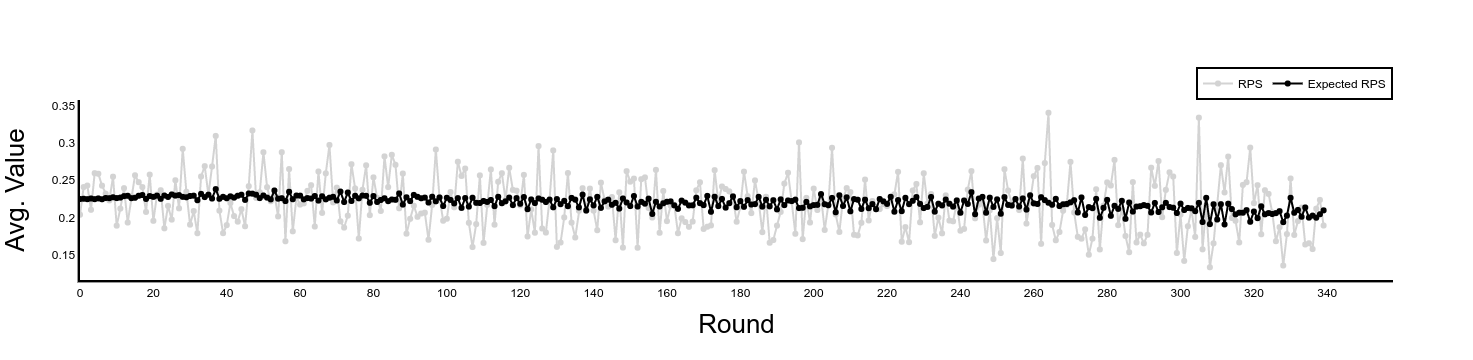

In [70]:
fig = go.Figure()
list_of_metrics = ["RPS", "TrueRPS", "ForecastError", "ExpectedRPS", "Forecastability"]
for rps_based_metric, color, display_name in [("RPS", "lightgray", "RPS"), ("ExpectedRPS", "black", "Expected RPS")]:
    fig.add_trace(
        go.Scatter(
            y=metrics_df[(rps_based_metric, "mean")],
            x=metrics_df["x_axis"],
            mode="lines+markers",
            name=display_name,
            line={
                "color": f"{color}",
                "width": 2
            }
        )
    )
return_fig_settings(fig, "Round", "Avg. Value")
fig.update_layout(showlegend=True)
fig.show(config=config)

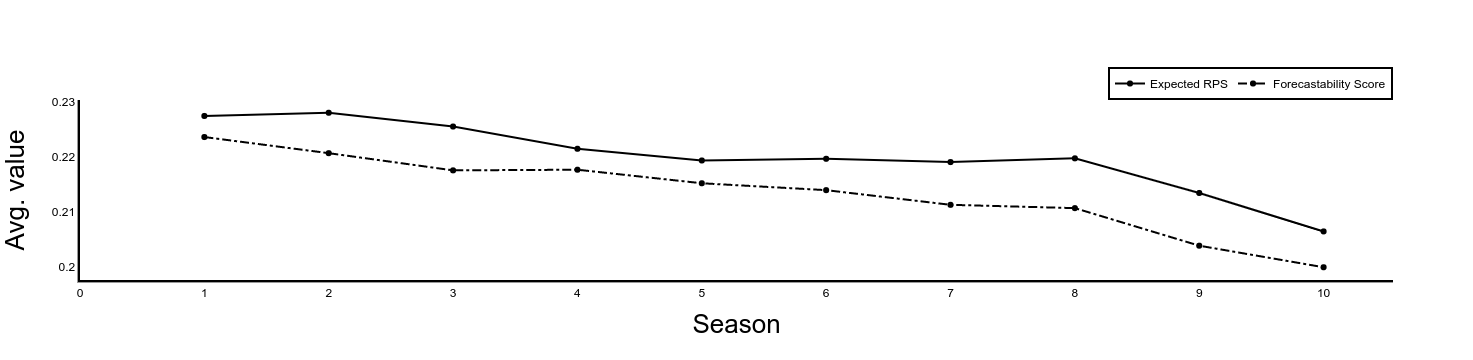

In [72]:
fig = go.Figure()
for rps_based_metric, dashed, display_name in [("ExpectedRPS", "solid", "Expected RPS"), ("Forecastability", "dashdot", "Forecastability Score")]:
    fig.add_trace(
        go.Scatter(
            y=season_df[(rps_based_metric, "mean")],
            x=season_df["Season"] + 1,
            mode="lines+markers",
            name=display_name,
            line= {
                "color": "black",
                "dash": dashed
            }
        )
    )
return_fig_settings(fig, "Season", "Avg. value")
fig.update_layout(showlegend=True)
fig.show(config=config)

Expected RPS excludes unsystematic error.
Forecastability(MINRPS), excluding both errors.
RPS-expectedRPS.
RPS-Forecastability.
The interesting thing is how this enables model comparison.

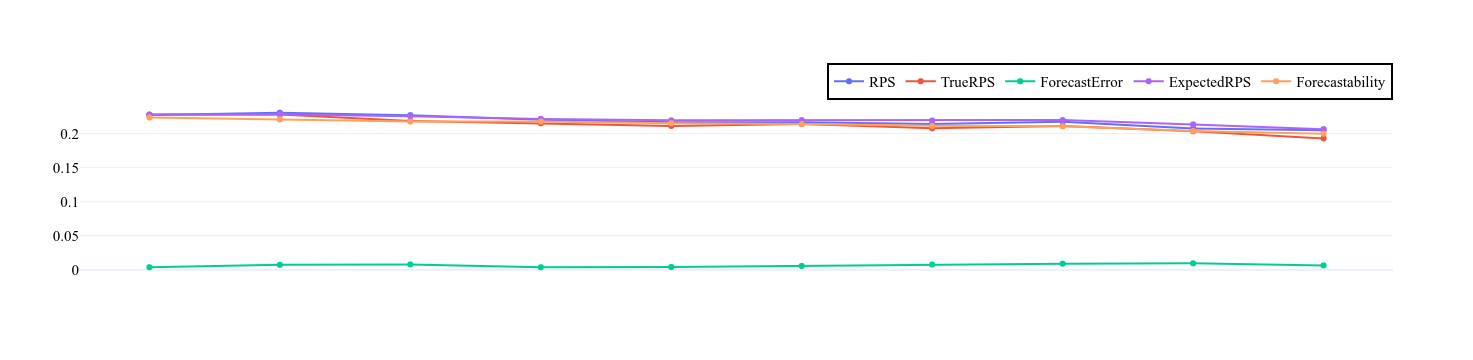

In [32]:
fig = go.Figure()
for rps_based_metric in ["RPS", "TrueRPS", "ForecastError", "ExpectedRPS", "Forecastability"]:
    fig.add_trace(
        go.Scatter(
            y=season_df[(rps_based_metric, "mean")],
            x=season_df["Season"] + 1,
            mode="lines+markers",
            name=rps_based_metric
        )
    )
return_fig_settings(fig, "", "")
fig.update_layout(showlegend=True)
fig.show(config=config)